In [1]:
from IPython.display import display
import pandas as pd
df = pd.read_csv('data/t2e/text_train.csv')
df = df.append(pd.read_csv('data/t2e/text_test.csv'))
display(df.head())

,wav_file,label,transcription
0,Ses04M_script03_1_F001,3,nobody knows we re here except freda and she w...
1,Ses03F_impro04_F011,4,really ?
2,Ses01M_script03_1_M003,3,we re okay right darling ? whatever happens we...
3,Ses04F_impro01_M001,2,you need a new license is that what you re tel...
4,Ses04F_script02_1_M028,4,for real ?


In [2]:
col = ['label', 'transcription']
df = df[col]

In [3]:
df.columns

Index(['label', 'transcription'], dtype='object')

In [4]:
df.columns = ['label', 'transcription']

In [5]:
from io import StringIO
category_to_id = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}
id_to_category = {0: 'ang', 1: 'hap', 2: 'sad', 3: 'fea', 4: 'sur', 5: 'neu'}

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('label').transcription.count().plot.bar(ylim=0)
plt.show()

<Figure size 800x600 with 1 Axes>

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.transcription).toarray()

labels = df.label
print(features.shape)

(9797, 2464)


In [8]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for emotion, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(emotion))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'ang':
  . Most correlated unigrams:
       . hate
       . turn
  . Most correlated bigrams:
       . did invite
       . look shaking
# 'fea':
  . Most correlated unigrams:
       . freda
       . wonder
  . Most correlated bigrams:
       . wouldn ring
       . good god
# 'hap':
  . Most correlated unigrams:
       . awesome
       . laughter
  . Most correlated bigrams:
       . behave exquisitely
       . great isn
# 'neu':
  . Most correlated unigrams:
       . okay
       . um
  . Most correlated bigrams:
       . ask marry
       . okay um
# 'sad':
  . Most correlated unigrams:
       . wonder
       . just
  . Most correlated bigrams:
       . don understand
       . good god
# 'sur':
  . Most correlated unigrams:
       . bed
       . real
  . Most correlated bigrams:
       . mean bed
       . oh really


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# X_train, y_train = df['transcription'], df['label']
# X_test, y_test = df_test['transcription'], df_test['label']


X_train, X_test, y_train, y_test = train_test_split(df['transcription'], df['label'], random_state=0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [10]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

[2]


In [11]:
print(clf.predict(count_vect.transform(["I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"])))

[2]


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
import xgboost as xgb

from sklearn.model_selection import cross_val_score


models = [
#     RandomForestClassifier(n_estimators=200, min_samples_split=10),
#      LinearSVC(),
#     MultinomialNB(),
#     xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
#                       n_estimators=100, sub_sample=0.8, num_class=len(category_to_id),
# #                       booster='gbtree', n_jobs=4),
#     MLPClassifier(hidden_layer_sizes=(200, ), activation='relu', solver='adam', alpha=0.0001,
#                   batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
#                   power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001,
#                   verbose=False, warm_start=True, momentum=0.8, nesterovs_momentum=True,
#                   early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
#                   epsilon=1e-08),
#     LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=200),
]
CV = 2
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

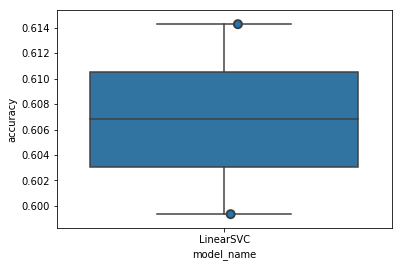

In [36]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [37]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC    0.606816
Name: accuracy, dtype: float64

In [15]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

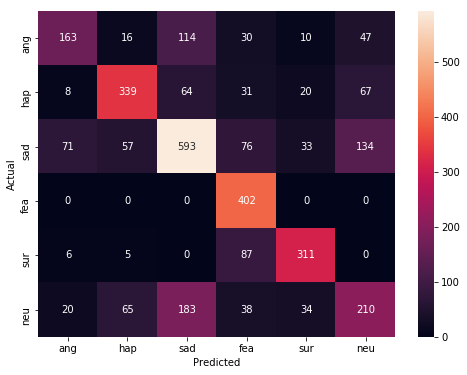

In [16]:
from sklearn.metrics import confusion_matrix
emotion_table = [['ang', 0], ['hap', 1], ['sad', 2], ['fea', 3], ['sur', 4], ['neu', 5]]
category_id_df = pd.DataFrame(emotion_table, columns=['emotion', 'label'])
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.emotion.values, yticklabels=category_id_df.emotion.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [17]:
# from IPython.display import display

# for predicted in category_id_df.label:
#     for actual in category_id_df.label:
#         if predicted != actual and conf_mat[actual, predicted] >= 6:
#             print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
#             display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['label', 'transcription']])

In [18]:
model.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [19]:
from sklearn.feature_selection import chi2

N = 2
for emotion, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(emotion))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'ang':
  . Top unigrams:
       . amanda
       . quiet
  . Top bigrams:
       . going like
       . finally forever
# 'fea':
  . Top unigrams:
       . wonder
       . iraq
  . Top bigrams:
       . good god
       . oh shall
# 'hap':
  . Top unigrams:
       . fun
       . poor
  . Top bigrams:
       . need glasses
       . guess came
# 'neu':
  . Top unigrams:
       . account
       . pain
  . Top bigrams:
       . ask marry
       . hard time
# 'sad':
  . Top unigrams:
       . loved
       . pictures
  . Top bigrams:
       . feel way
       . filled wrong
# 'sur':
  . Top unigrams:
       . bed
       . real
  . Top bigrams:
       . god sorry
       . going care


In [38]:
texts = ["Are you crazy!",
         "I am not going to die right?",
         "This is fantastic!",
         "Okay",
         "That's sad",
         "Oh, really?"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

NotFittedError: This LinearSVC instance is not fitted yet